In [1]:
import json
import ast
import textwrap
from typing import Dict, Any, List, Tuple
import os
import importlib.util


In [2]:
def import_dsl_functions(dsl_file_path: str) -> Dict[str, Any]:
    spec = importlib.util.spec_from_file_location("dsl", dsl_file_path)
    dsl_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(dsl_module)
    return {name: getattr(dsl_module, name) for name in dir(dsl_module) if not name.startswith('_')}

def execute_sub_function(sub_function_str: str, input_grid: Tuple[Tuple[int, ...], ...], dsl_functions: Dict[str, Any], constants: Dict[str, Any]) -> Tuple[Tuple[int, ...], ...]:
    # Parse the sub-function string
    sub_function_ast = ast.parse(sub_function_str).body[0].value

    def eval_node(node):
        if isinstance(node, ast.Call):
            func_name = node.func.id
            args = [eval_node(arg) for arg in node.args]
            return dsl_functions[func_name](*args)
        elif isinstance(node, ast.Name):
            if node.id == 'I':
                return input_grid
            elif node.id in constants:
                return constants[node.id]
            elif node.id in dsl_functions:
                return dsl_functions[node.id]
            else:
                raise NameError(f"Name '{node.id}' is not defined")
        elif isinstance(node, ast.Num):
            return node.n
        else:
            raise ValueError(f"Unsupported node type: {type(node)}")

    return eval_node(sub_function_ast)


In [3]:
dsl_functions = import_dsl_functions('dsl.py')

In [4]:
import sys

In [5]:
def read_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        return file.read()
def parse_constants(code: str) -> Dict[str, Any]:
    tree = ast.parse(code)
    constants = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.Assign):
            for target in node.targets:
                if isinstance(target, ast.Name) and target.id.isupper():
                    if isinstance(node.value, ast.Num):
                        constants[target.id] = node.value.n
                    elif isinstance(node.value, ast.UnaryOp) and isinstance(node.value.op, ast.USub):
                        # Handle negative numbers
                        constants[target.id] = -node.value.operand.n
                    elif isinstance(node.value, ast.Tuple):
                        constants[target.id] = tuple(
                            elt.n if isinstance(elt, ast.Num) 
                            else -elt.operand.n if isinstance(elt, ast.UnaryOp) and isinstance(elt.op, ast.USub)
                            else None 
                            for elt in node.value.elts
                        )
                    elif sys.version_info >= (3, 8) and isinstance(node.value, ast.Constant):
                        # Handle booleans and other constants in Python 3.8+
                        constants[target.id] = node.value.value
                    elif sys.version_info < (3, 8) and isinstance(node.value, ast.NameConstant):
                        # Handle booleans in Python 3.7 and earlier
                        constants[target.id] = node.value.value
    return constants



In [6]:
constants_code = read_file('constants.py')
constants = parse_constants(constants_code)


In [7]:
def references_input_grid(func_def: ast.FunctionDef) -> bool:
    """
    Check if the function references the input grid 'I'.
    
    :param func_def: The AST node of the function definition
    :return: True if the function references 'I', False otherwise
    """
    class InputGridVisitor(ast.NodeVisitor):
        def __init__(self):
            self.references_i = False

        def visit_Name(self, node):
            if node.id == 'I':
                self.references_i = True
            self.generic_visit(node)

    visitor = InputGridVisitor()
    visitor.visit(func_def)
    return visitor.references_i


In [8]:
def plot_task(
    task: List[dict],
    title: str = None
) -> None:
    """
    displays a task
    """
    cmap = ListedColormap([
        '#000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
    ])
    norm = Normalize(vmin=0, vmax=9)
    args = {'cmap': cmap, 'norm': norm}
    height = 2
    width = len(task)
    figure_size = (width * 3, height * 3)
    figure, axes = plt.subplots(height, width, figsize=figure_size)
    if width > 1:
        for column, example in enumerate(task):
            axes[0, column].imshow(example['input'], **args)
            axes[1, column].imshow(example['output'], **args)
            axes[0, column].axis('off')
            axes[1, column].axis('off')
    else:
        example=task[0]
        axes[0].imshow(example['input'], **args)
        axes[1].imshow(example['output'], **args)
        axes[0].axis('off')
        axes[1].axis('off')
    if title is not None:
        figure.suptitle(title, fontsize=20)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [9]:
def get_data(train=True):
    path = f'arc_original/{"training" if train else "evaluation"}'
    data = {}
    for fn in os.listdir(path):
        with open(f'{path}/{fn}') as f:
            data[fn.rstrip('.json')] = json.load(f)
    ast = lambda g: tuple(tuple(r) for r in g)
    return {
        'train': {k: [{
            'input': ast(e['input']),
            'output': ast(e['output']),
        } for e in v['train']] for k, v in data.items()},
        'test': {k: [{
            'input': ast(e['input']),
            'output': ast(e['output']),
        } for e in v['test']] for k, v in data.items()}
    }


In [10]:
with open("incremental_arc_examples.json", 'r') as fp:
    inc_examples = json.load(fp)

with open("incremental_arc_solutions.json", 'r') as fp:
    incr_programs = json.load(fp)

In [11]:
with open("incremental_input_grid_arc_examples.json", 'r') as fp:
    relabeled_examples = json.load(fp)

with open("incremental_input_grid_arc_solutions.json", 'r') as fp:
    relabeled_solns = json.load(fp)

In [12]:
inc_examples['train'].keys()

dict_keys(['5614dbcf_0', 'f25ffba3_0', 'f25ffba3_1', '28bf18c6_0', '28bf18c6_1', '3af2c5a8_0', '3af2c5a8_1', '62c24649_0', '62c24649_1', '67e8384a_0', '67e8384a_1', '7468f01a_0', '46f33fce_0', '46f33fce_1', '46f33fce_2', 'a740d043_0', 'a79310a0_0', 'aabf363d_0', 'aabf363d_1', 'f25fbde4_0', '1e0a9b12_0', '0d3d703e_0', '0d3d703e_1', '0d3d703e_2', '1c786137_0', '2013d3e2_0', '2013d3e2_1', '9565186b_0', 'e98196ab_0', 'e98196ab_1', 'f76d97a5_0', 'ce9e57f2_0', '9f236235_0', '46442a0e_0', '46442a0e_1', '46442a0e_2', '46442a0e_3', '46442a0e_4', '7fe24cdd_0', '7fe24cdd_1', '7fe24cdd_2', '7fe24cdd_3', '7fe24cdd_4', '0ca9ddb6_0', '543a7ed5_0', '0520fde7_0', '0520fde7_1', '0520fde7_2', 'dae9d2b5_0', 'dae9d2b5_1', 'dae9d2b5_2', '8d5021e8_0', '8d5021e8_1', '8d5021e8_2', '8d5021e8_3', '8d5021e8_4', '928ad970_0', '928ad970_1', 'b60334d2_0', 'b60334d2_1', 'b94a9452_0', 'b94a9452_1', 'b94a9452_2', 'd0f5fe59_0', 'e3497940_0', 'e3497940_1', 'e9afcf9a_0', 'e9afcf9a_1', 'e9afcf9a_2', 'e9afcf9a_3', 'e9afcf9a

In [13]:
data = get_data()

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize


In [15]:
incr_programs["f25ffba3_0"]

'bottomhalf(I)'

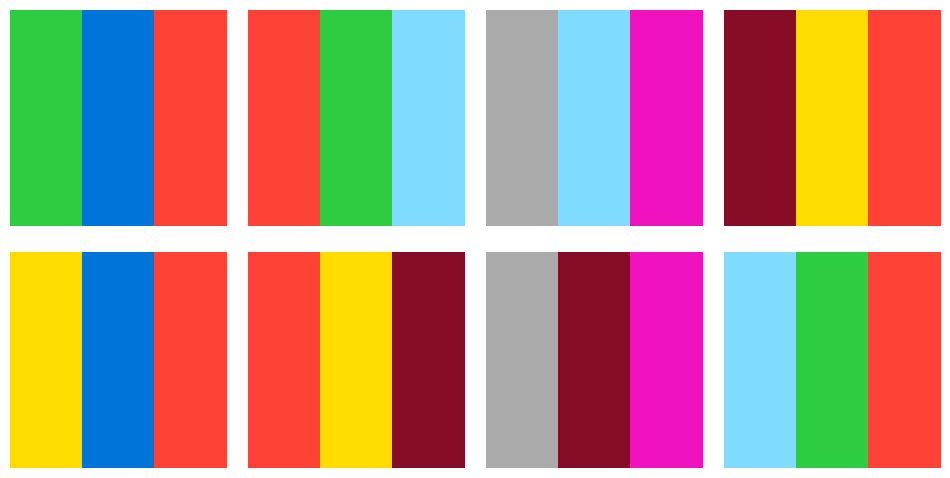

In [16]:
plot_task(inc_examples['train']["0d3d703e_1"])

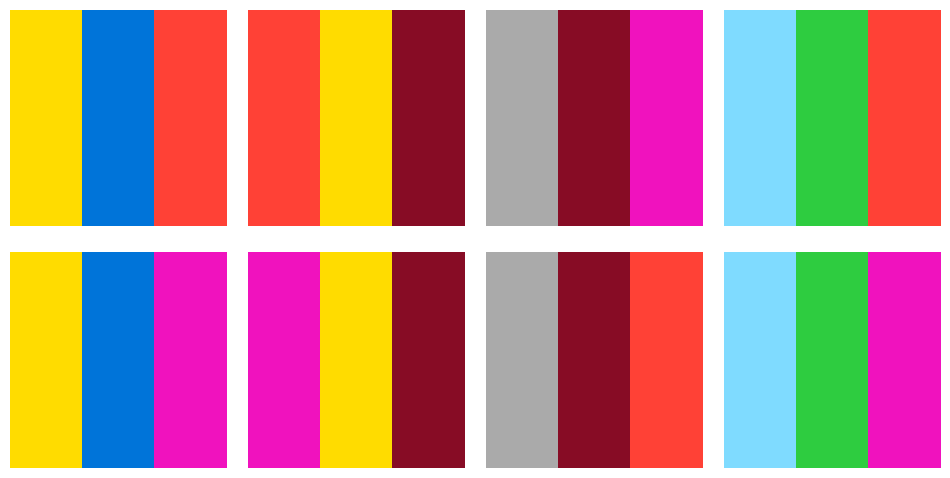

In [17]:
plot_task(relabeled_examples['train']['0d3d703e_incr_input_2'])

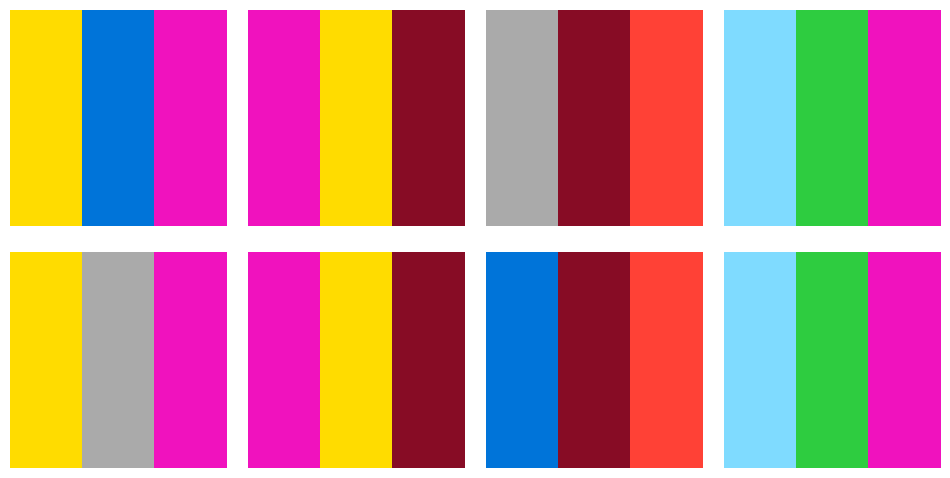

In [18]:
plot_task(relabeled_examples['train']['0d3d703e_incr_input_0'])

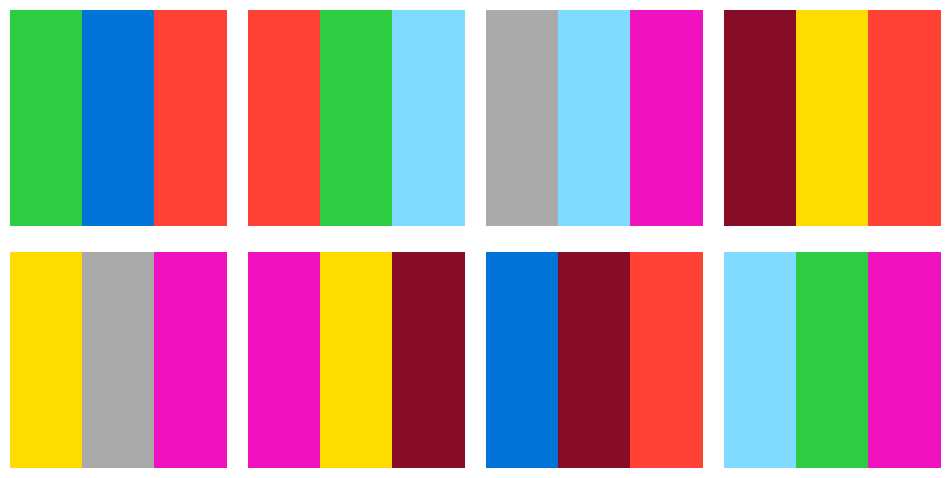

In [19]:
plot_task(data['train']['0d3d703e'])

In [20]:
inc_examples['train']["5614dbcf_0"]

[{'input': [[3, 3, 3, 0, 0, 0, 8, 8, 8],
   [3, 3, 3, 0, 0, 0, 8, 5, 8],
   [3, 3, 3, 0, 0, 0, 8, 8, 8],
   [0, 0, 0, 7, 5, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [6, 6, 6, 0, 0, 5, 9, 9, 9],
   [6, 6, 6, 0, 0, 0, 9, 9, 9],
   [6, 5, 6, 0, 5, 0, 9, 9, 5]],
  'output': [[3, 3, 3, 0, 0, 0, 8, 8, 8],
   [3, 3, 3, 0, 0, 0, 8, 0, 8],
   [3, 3, 3, 0, 0, 0, 8, 8, 8],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [6, 6, 6, 0, 0, 0, 9, 9, 9],
   [6, 6, 6, 0, 0, 0, 9, 9, 9],
   [6, 0, 6, 0, 0, 0, 9, 9, 0]]},
 {'input': [[0, 0, 0, 2, 2, 2, 0, 0, 0],
   [0, 5, 0, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 2, 2, 2, 0, 0, 0],
   [5, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 5, 0, 0, 0, 5, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 5, 0, 7, 7, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 5, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0]],
  'output': [[0, 0, 0, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 2, 2, 2, 0, 0, 0]

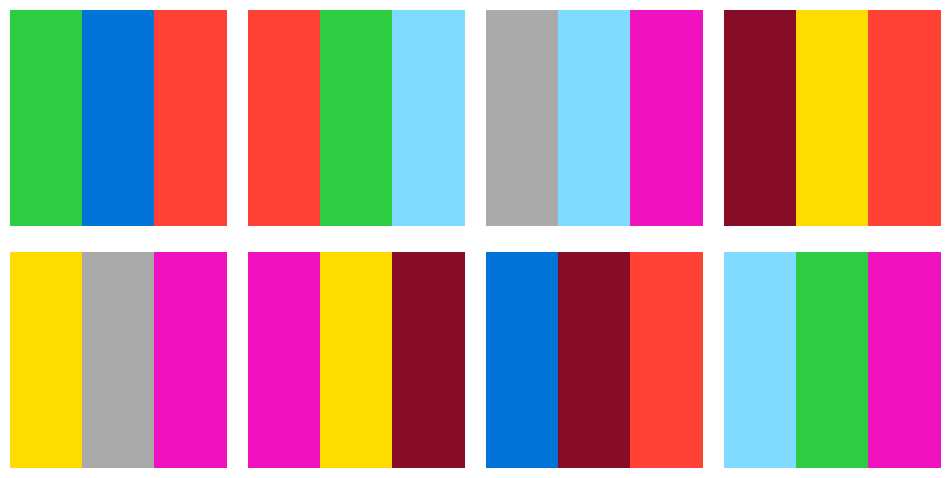

In [21]:
plot_task(data['train']['0d3d703e'])

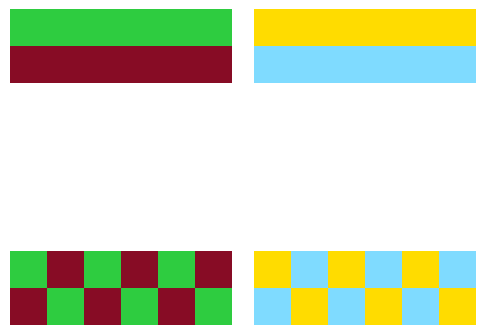

In [22]:
plot_task(data['train']["e9afcf9a"])

In [23]:
relabeled_examples['train']['5614dbcf_incr_input_0']

[{'input': [[3, 3, 3, 0, 0, 0, 8, 8, 8],
   [3, 3, 3, 0, 0, 0, 8, 0, 8],
   [3, 3, 3, 0, 0, 0, 8, 8, 8],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [6, 6, 6, 0, 0, 0, 9, 9, 9],
   [6, 6, 6, 0, 0, 0, 9, 9, 9],
   [6, 0, 6, 0, 0, 0, 9, 9, 0]],
  'output': [[3, 0, 8], [0, 7, 0], [6, 0, 9]]},
 {'input': [[0, 0, 0, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 2, 2, 2, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 0, 0, 0, 0],
   [0, 0, 0, 7, 7, 7, 0, 0, 0]],
  'output': [[0, 2, 0], [0, 0, 0], [0, 7, 0]]}]

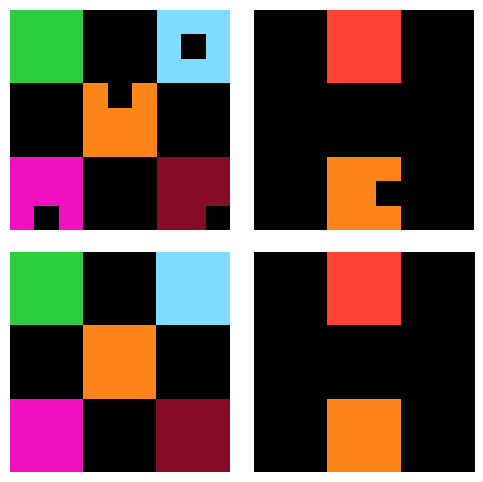

In [24]:
plot_task(relabeled_examples['train']['5614dbcf_incr_input_0'])

In [25]:
inc_examples['train']["5614dbcf_0"][0]['output'] == relabeled_examples['train']['5614dbcf_incr_input_0'][0]['input']

True

In [26]:
def convert_to_tuples(list_of_lists):
    return tuple(tuple(t) for t in list_of_lists)

In [27]:
def construct_key_trajectory(inc_input_key, incr_data, relabeled_data, orig_data):
    task_key = inc_input_key.split("_")[0]
    # orig_examples = 
    potential_relabeled_keys = [k for k in list(relabeled_data['train'].keys()) if task_key == k.split("_")[0]]
    incr_examples = incr_data['train'][inc_input_key]
    orig_examples = orig_data['train'][task_key]
    curr_output = incr_examples[0]['output']
    final_output = orig_examples[0]['output']
    trajectory = []
    while convert_to_tuples(curr_output) != final_output:
        
        for key in potential_relabeled_keys:
            if curr_output == relabeled_data['train'][key][0]['input']:
                trajectory.append(key)
                curr_output = relabeled_data['train'][key][0]['output']
                # print(curr_output, final_output)
                break
                
        # break
    
    return trajectory
        
    
    
    

In [28]:
from collections import deque

class TrajectoryNode:
    def __init__(self, key, outputs):
        self.key = key
        self.outputs = outputs
        self.children = []

    def add_child(self, child):
        self.children.append(child)

def construct_key_trajectory_tree(inc_input_key, incr_data, relabeled_data, orig_data):
    task_key = inc_input_key.split("_")[0]
    potential_relabeled_keys = [k for k in relabeled_data['train'].keys() if task_key == k.split("_")[0]]
    incr_examples = incr_data['train'][inc_input_key]
    orig_examples = orig_data['train'][task_key]

    initial_outputs = [incr_ex['output'] for incr_ex in incr_examples]
    final_outputs = [orig_ex['output'] for orig_ex in orig_examples]

    root = TrajectoryNode(inc_input_key, initial_outputs)

    def build_tree(node):
        if all(output in final_outputs for output in node.outputs):
            return

        for key in potential_relabeled_keys:
            relabeled_examples = relabeled_data['train'][key]
            if all(node_output == relabeled_ex['input'] for node_output, relabeled_ex in zip(node.outputs, relabeled_examples)):
                child_outputs = [relabeled_ex['output'] for relabeled_ex in relabeled_examples]
                child_node = TrajectoryNode(key, child_outputs)
                node.add_child(child_node)
                build_tree(child_node)

    build_tree(root)
    return root

def print_tree_top_down(root):
    if not root:
        return

    queue = deque([(root, 0)])
    current_level = 0
    level_nodes = []

    while queue:
        node, level = queue.popleft()

        if level > current_level:
            print(" | ".join(f"{n.key}: {n.output}" for n in level_nodes))
            level_nodes = []
            current_level = level

        level_nodes.append(node)

        for child in node.children:
            queue.append((child, level + 1))

    # Print the last level
    if level_nodes:
        print(" | ".join(f"{n.key}: {n.output}" for n in level_nodes))

def pretty_print_tree(root):
    if not root:
        return

    def get_tree_height(node):
        if not node.children:
            return 1
        return 1 + max(get_tree_height(child) for child in node.children)

    def print_node(node, prefix, is_last, height):
        print(prefix + ("└── " if is_last else "├── ") + f"{node.key}: {node.output}")
        
        child_prefix = prefix + ("    " if is_last else "│   ")
        for i, child in enumerate(node.children):
            is_last_child = i == len(node.children) - 1
            print_node(child, child_prefix, is_last_child, height - 1)

    tree_height = get_tree_height(root)
    print_node(root, "", True, tree_height)

def print_grid(grid):
    """
    Prints a grid using ASCII characters.
    """
    color_map = {
        0: '⬛', 1: '🟦', 2: '🟥', 3: '🟩', 4: '🟨',
        5: '⬜', 6: '🟪', 7: '🟧', 8: '🟫', 9: '🟫'
    }
    for row in grid:
        print(''.join(color_map[cell] for cell in row))

def pretty_print_tree_with_grids(root, incr_data, relabeled_data):
    if not root:
        return

    def print_node_with_grid(node, prefix, is_last):
        print(prefix + ("└── " if is_last else "├── ") + f"{node.key}:")
        
        # Determine the correct dataset and key to use
        if node.key in incr_data['train']:
            data = incr_data['train'][node.key]
        elif node.key in relabeled_data['train']:
            data = relabeled_data['train'][node.key]
        else:
            print(f"Error: Key {node.key} not found in datasets")
            return

        # Print input grid
        print(prefix + ("    " if is_last else "│   ") + "Input:")
        print_grid(data[0]['input'])
        
        # Print output grid
        print(prefix + ("    " if is_last else "│   ") + "Output:")
        print_grid(data[0]['output'])
        print()  # Add a blank line for readability

        # Recursively print child nodes
        child_prefix = prefix + ("    " if is_last else "│   ")
        for i, child in enumerate(node.children):
            is_last_child = i == len(node.children) - 1
            print_node_with_grid(child, child_prefix, is_last_child)

    print_node_with_grid(root, "", True)

def print_grid(grid):
    color_map = {
        0: '⬛', 1: '🟦', 2: '🟥', 3: '🟩', 4: '🟨',
        5: '⬜', 6: '🟪', 7: '🟧', 8: '🟫', 9: '🟫'
    }
    return '\n'.join(''.join(color_map[cell] for cell in row) for row in grid)

def calculate_tree_width(root):
    if not root.children:
        return 1
    return sum(calculate_tree_width(child) for child in root.children)

def centered_vertical_tree_with_grids(root, incr_data, relabeled_data, final_outputs=None):
    def get_node_content(node):
        if node.key in incr_data['train']:
            data = incr_data['train'][node.key]
        elif node.key in relabeled_data['train']:
            data = relabeled_data['train'][node.key]
        else:
            return f"Error: Key {node.key} not found in datasets"

        content = f"{node.key}\n"
        for i, (example, output) in enumerate(zip(data, node.outputs)):
            content += f"Example {i+1}:\n"
            content += f"Input:\n{print_grid(example['input'])}\n"
            content += f"Output:\n{print_grid(output)}\n"
        return content.strip()

    def is_final_output(node):
        if final_outputs is None:
            return False
        return all(output in final_outputs for output in node.outputs)

    def layout_tree(node, x, y, width, is_highlighted_path=False):
        node_content = get_node_content(node).split('\n')
        node_height = len(node_content)
        node_width = max(len(line) for line in node_content)
        
        # Center the node content
        centered_content = [line.center(width) for line in node_content]
        
        for i, line in enumerate(centered_content):
            grid[y + i][x:x + width] = line

        if not node.children:
            return is_highlighted_path or is_final_output(node)

        child_width = width // len(node.children)
        any_child_highlighted = False

        for i, child in enumerate(node.children):
            child_x = x + i * child_width
            child_y = y + node_height + 1
            
            child_highlighted = layout_tree(child, child_x, child_y, child_width, is_highlighted_path)
            any_child_highlighted = any_child_highlighted or child_highlighted

            # Draw vertical line
            for line_y in range(y + node_height, child_y):
                if child_highlighted:
                    grid[line_y][x + width // 2] = colorama.Fore.RED + '│' + colorama.Fore.RESET
                else:
                    grid[line_y][x + width // 2] = '│'
            
            # Draw horizontal line
            hline_y = child_y - 1
            hline_start = child_x + child_width // 2
            hline_end = x + width // 2
            for hline_x in range(min(hline_start, hline_end), max(hline_start, hline_end) + 1):
                if child_highlighted:
                    grid[hline_y][hline_x] = colorama.Fore.RED + '─' + colorama.Fore.RESET
                else:
                    grid[hline_y][hline_x] = '─'
            
            # Draw corner
            if child_highlighted:
                grid[hline_y][x + width // 2] = colorama.Fore.RED + '┴' + colorama.Fore.RESET
            else:
                grid[hline_y][x + width // 2] = '┴'

        return any_child_highlighted or is_highlighted_path or is_final_output(node)

    total_width = calculate_tree_width(root) * 30  # Increased multiplier for wider nodes
    total_height = 2000  # Increased height for potentially larger trees
    grid = [[' ' for _ in range(total_width)] for _ in range(total_height)]

    layout_tree(root, 0, 0, total_width)

    # Trim empty rows and print
    content_rows = [row for row in grid if set(row) != {' '}]
    for row in content_rows:
        print(''.join(row).rstrip())

# Example usage
# trajectory_tree = construct_key_trajectory_tree(inc_input_key, incr_data, relabeled_data, orig_data)
# print_tree_top_down(trajectory_tree)

In [30]:
# pretty_print_tree(construct_key_trajectory_tree("e9afcf9a_3", inc_examples, relabeled_examples, data))

In [32]:
# centered_vertical_tree_with_grids(construct_key_trajectory_tree("e9afcf9a_6", inc_examples, relabeled_examples, data), inc_examples, relabeled_examples, final_output=data['train']['e9afcf9a'][0]['output'])

In [33]:
construct_key_trajectory("e9afcf9a_3", inc_examples, relabeled_examples, data)

['e9afcf9a_incr_input_2']

In [34]:
inc_key = "5614dbcf_0"
curr_output = inc_examples['train']["5614dbcf_0"][0]['output']
task_key = inc_key.split("_")[0]
potential_relabeled_keys = [k for k in list(relabeled_examples['train'].keys()) if task_key == k.split("_")[0]]
final_output = data['train'][task_key][0]['output']
for key in potential_relabeled_keys:
    if curr_output == relabeled_examples['train'][key][0]['input']:
        print(relabeled_examples['train'][key][0]['output'])

[[3, 0, 8], [0, 7, 0], [6, 0, 9]]


In [35]:
final_output

((3, 0, 8), (0, 7, 0), (6, 0, 9))

In [36]:
convert_to_tuples(relabeled_examples['train'][key][0]['output']) == final_output

True

In [37]:
trees = [construct_key_trajectory_tree(k, inc_examples, relabeled_examples, data) for k in inc_examples['train'].keys()]

In [38]:
trees = []
for k in inc_examples['train'].keys():
    trees.append(construct_key_trajectory_tree(k, inc_examples, relabeled_examples, data))

In [39]:
centered_vertical_tree_with_grids(construct_key_trajectory_tree(k, inc_examples, relabeled_examples, data),inc_examples, relabeled_examples)

         97a05b5b_15
          Example 1:
            Input:
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥⬛🟥🟥🟥🟥🟥⬛🟥⬛⬛🟦🟥🟦⬛⬛⬛
     ⬛⬛🟥⬛⬛🟥🟥🟥🟥⬛🟥⬛⬛🟥🟥🟥⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥⬛🟥⬛⬛🟦🟥🟦⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥⬛🟥🟥🟥🟥⬛⬛⬛🟩🟩🟩⬛⬛
     ⬛⬛🟥🟥🟥⬛⬛⬛🟥🟥🟥⬛⬛⬛🟥🟥🟥⬛⬛
     ⬛⬛🟥🟥🟥🟥⬛🟥🟥🟥🟥⬛⬛⬛🟩🟩🟩⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥⬛⬛🟥🟥🟥⬛🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥⬛🟥🟥🟥⬛🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥⬛⬛🟥🟥⬛⬛⬛🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛🟫🟫🟫⬛⬛
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟥🟫🟥⬛⬛
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟥🟥🟥⬛⬛
     ⬛⬛⬛🟨🟨🟨⬛⬛⬜⬜🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛⬛🟨🟥🟨⬛⬛🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛⬛🟥🟥🟨⬛⬛⬜⬜🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛
           Output:
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥⬛🟥🟥🟥🟥🟥⬛🟥
          🟥⬛⬛🟥🟥🟥🟥⬛🟥
          🟥🟥🟥🟥🟥🟥🟥⬛🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥⬛🟥🟥🟥🟥
          🟥🟥🟥⬛⬛⬛🟥🟥🟥
          🟥🟥🟥🟥⬛🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥⬛⬛🟥🟥🟥⬛🟥🟥
          🟥🟥⬛🟥🟥🟥⬛🟥🟥
          🟥⬛⬛🟥🟥⬛⬛⬛🟥


In [62]:
centered_vertical_tree_with_grids(trees[-1],inc_examples, relabeled_examples)

         97a05b5b_15
          Example 1:
            Input:
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥⬛🟥🟥🟥🟥🟥⬛🟥⬛⬛🟦🟥🟦⬛⬛⬛
     ⬛⬛🟥⬛⬛🟥🟥🟥🟥⬛🟥⬛⬛🟥🟥🟥⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥⬛🟥⬛⬛🟦🟥🟦⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥⬛🟥🟥🟥🟥⬛⬛⬛🟩🟩🟩⬛⬛
     ⬛⬛🟥🟥🟥⬛⬛⬛🟥🟥🟥⬛⬛⬛🟥🟥🟥⬛⬛
     ⬛⬛🟥🟥🟥🟥⬛🟥🟥🟥🟥⬛⬛⬛🟩🟩🟩⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥⬛⬛🟥🟥🟥⬛🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥⬛🟥🟥🟥⬛🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥⬛⬛🟥🟥⬛⬛⬛🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛🟥🟥🟥🟥🟥🟥🟥🟥🟥⬛⬛⬛🟫🟫🟫⬛⬛
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟥🟫🟥⬛⬛
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟥🟥🟥⬛⬛
     ⬛⬛⬛🟨🟨🟨⬛⬛⬜⬜🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛⬛🟨🟥🟨⬛⬛🟥🟥🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛⬛🟥🟥🟨⬛⬛⬜⬜🟥⬛⬛⬛⬛⬛⬛⬛⬛
     ⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛
           Output:
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥⬛🟥🟥🟥🟥🟥⬛🟥
          🟥⬛⬛🟥🟥🟥🟥⬛🟥
          🟥🟥🟥🟥🟥🟥🟥⬛🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥⬛🟥🟥🟥🟥
          🟥🟥🟥⬛⬛⬛🟥🟥🟥
          🟥🟥🟥🟥⬛🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥🟥🟥🟥🟥🟥🟥🟥🟥
          🟥⬛⬛🟥🟥🟥⬛🟥🟥
          🟥🟥⬛🟥🟥🟥⬛🟥🟥
          🟥⬛⬛🟥🟥⬛⬛⬛🟥


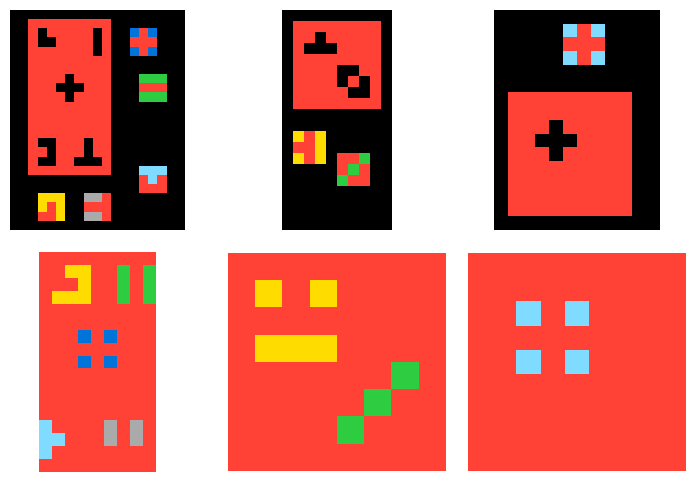

In [65]:
plot_task(data['train']['97a05b5b'])

In [66]:
relabeled_examples['train'].keys()

dict_keys(['5614dbcf_incr_input_0', 'f25ffba3_incr_input_0', '28bf18c6_incr_input_0', '3af2c5a8_incr_input_0', '62c24649_incr_input_0', '67e8384a_incr_input_0', '46f33fce_incr_input_0', '46f33fce_incr_input_1', '46f33fce_incr_input_2', 'a740d043_incr_input_0', 'a79310a0_incr_input_0', '1e0a9b12_incr_input_0', '0d3d703e_incr_input_0', '0d3d703e_incr_input_1', '0d3d703e_incr_input_2', '0d3d703e_incr_input_3', '0d3d703e_incr_input_4', '0d3d703e_incr_input_5', '1c786137_incr_input_0', '2013d3e2_incr_input_0', '2013d3e2_incr_input_1', '2013d3e2_incr_input_2', 'f76d97a5_incr_input_0', 'ce9e57f2_incr_input_0', '0520fde7_incr_input_0', '8d5021e8_incr_input_0', '8d5021e8_incr_input_1', '928ad970_incr_input_0', 'b94a9452_incr_input_0', 'd0f5fe59_incr_input_0', 'e9afcf9a_incr_input_0', 'e9afcf9a_incr_input_1', 'e9afcf9a_incr_input_2', 'e9afcf9a_incr_input_3', 'e9afcf9a_incr_input_4', '3906de3d_incr_input_0', '3906de3d_incr_input_1', '3906de3d_incr_input_2', '7b6016b9_incr_input_0', '10fcaaa3_incr

In [64]:
corrects[-1]

['a8c38be5_0', 'a8c38be5_incr_input_0']

In [40]:
len(trees)

1349

In [41]:
from typing import List, Dict, Any

def extract_correct_trajectories(trees: List[TrajectoryNode], orig_data: Dict[str, Any]) -> List[List[str]]:
    """
    Extract trajectories leading to the correct final answers from a list of trajectory trees.
    
    :param trees: List of root nodes of trajectory trees
    :param orig_data: Original data containing the final outputs
    :return: List of correct trajectories, where each trajectory is a list of node keys
    """
    correct_trajectories = []

    def get_final_outputs(root_key: str) -> List[Any]:
        task_key = root_key.split("_")[0]
        return [ex['output'] for ex in orig_data['train'][task_key]]

    def dfs(node: TrajectoryNode, current_path: List[str], final_outputs: List[Any]):
        # Check if the current node's outputs match the final outputs
        if all(convert_to_tuples(output) in final_outputs for output in node.outputs):
            correct_trajectories.append(current_path.copy())
            return

        # If this is a leaf node and doesn't match final outputs, we can return
        if not node.children:
            return

        # Recursively explore children
        for child in node.children:
            current_path.append(child.key)
            dfs(child, current_path, final_outputs)
            current_path.pop()

    # Perform DFS on each tree
    for tree in trees:
        final_outputs = get_final_outputs(tree.key)
        dfs(tree, [tree.key], final_outputs)

    return correct_trajectories

# Example usage:
# Assuming we have a list of trees and the original data
# trees = [tree1, tree2, tree3, ...]
# orig_data = {...}
# correct_trajectories = extract_correct_trajectories(trees, orig_data)

# Function to print the extracted trajectories
def print_trajectories(trajectories: List[List[str]]):
    for i, trajectory in enumerate(trajectories, 1):
        print(f"Trajectory {i}: {' -> '.join(trajectory)}")

# print_trajectories(correct_trajectories)

# Additional helper function to get all unique steps in the correct trajectories
def get_unique_steps(trajectories: List[List[str]]) -> List[str]:
    unique_steps = set()
    for trajectory in trajectories:
        unique_steps.update(trajectory)
    return sorted(list(unique_steps))

# unique_steps = get_unique_steps(correct_trajectories)
# print("Unique steps in correct trajectories:", unique_steps)

In [42]:
corrects = extract_correct_trajectories(trees, data)

In [43]:
corrects

[['5614dbcf_0', '5614dbcf_incr_input_0'],
 ['f25ffba3_0', 'f25ffba3_incr_input_0'],
 ['f25ffba3_1', 'f25ffba3_incr_input_0'],
 ['28bf18c6_0', '28bf18c6_incr_input_0'],
 ['28bf18c6_1', '28bf18c6_incr_input_0'],
 ['3af2c5a8_0', '3af2c5a8_incr_input_0'],
 ['3af2c5a8_1', '3af2c5a8_incr_input_0'],
 ['62c24649_0', '62c24649_incr_input_0'],
 ['62c24649_1', '62c24649_incr_input_0'],
 ['67e8384a_0', '67e8384a_incr_input_0'],
 ['67e8384a_1', '67e8384a_incr_input_0'],
 ['a740d043_0', 'a740d043_incr_input_0'],
 ['a79310a0_0', 'a79310a0_incr_input_0'],
 ['1e0a9b12_0', '1e0a9b12_incr_input_0'],
 ['0d3d703e_1', '0d3d703e_incr_input_1'],
 ['0d3d703e_1', '0d3d703e_incr_input_2', '0d3d703e_incr_input_0'],
 ['0d3d703e_2', '0d3d703e_incr_input_3'],
 ['0d3d703e_2', '0d3d703e_incr_input_4', '0d3d703e_incr_input_0'],
 ['0d3d703e_2', '0d3d703e_incr_input_5', '0d3d703e_incr_input_1'],
 ['0d3d703e_2',
  '0d3d703e_incr_input_5',
  '0d3d703e_incr_input_2',
  '0d3d703e_incr_input_0'],
 ['1c786137_0', '1c786137_inc

In [44]:
def collect_subroutines(correct_traj, incr_examples, incr_programs, relabeled_examples, relabeled_programs, split='train'):
    first_step = correct_traj[0]
    subroutine_0_prog = incr_programs[first_step]
    subroutine_0 = {
        "inputs": [ex['input'] for ex in incr_examples[split][first_step]],
        "outputs": [ex['output'] for ex in incr_examples[split][first_step]],
        "program": subroutine_0_prog
    }
    curr_subroutine = 1
    routines = {}
    routines["subroutine_0"] = subroutine_0
    for step in correct_traj[1:]:
        prog = relabeled_programs[step]
        subroutine = {
        "inputs": [ex['input'] for ex in relabeled_examples[split][step]],
        "outputs": [ex['output'] for ex in relabeled_examples[split][step]],
        "program": prog
        }
        routines[f"subroutine_{curr_subroutine}"] = subroutine
        curr_subroutine += 1

    output = {
        "original_task_key": first_step.split("_")[0],
        "subroutines": routines
    }
    return output

In [45]:
collect_subroutines(corrects[0], inc_examples, incr_programs, relabeled_examples, relabeled_solns)

{'original_task_key': '5614dbcf',
 'subroutines': {'subroutine_0': {'inputs': [[[3, 3, 3, 0, 0, 0, 8, 8, 8],
     [3, 3, 3, 0, 0, 0, 8, 5, 8],
     [3, 3, 3, 0, 0, 0, 8, 8, 8],
     [0, 0, 0, 7, 5, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [6, 6, 6, 0, 0, 5, 9, 9, 9],
     [6, 6, 6, 0, 0, 0, 9, 9, 9],
     [6, 5, 6, 0, 5, 0, 9, 9, 5]],
    [[0, 0, 0, 2, 2, 2, 0, 0, 0],
     [0, 5, 0, 2, 2, 2, 0, 0, 0],
     [0, 0, 0, 2, 2, 2, 0, 0, 0],
     [5, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 5, 0, 0, 0, 5, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 5, 0, 7, 7, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 5, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0]]],
   'outputs': [[[3, 3, 3, 0, 0, 0, 8, 8, 8],
     [3, 3, 3, 0, 0, 0, 8, 0, 8],
     [3, 3, 3, 0, 0, 0, 8, 8, 8],
     [0, 0, 0, 7, 0, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [6, 6, 6, 0, 0, 0, 9, 9, 9],
     [6, 6, 6, 0, 0, 0, 9, 9, 9],
     [6, 0, 6, 0, 0, 0, 9, 

In [46]:
all_train_routines = [collect_subroutines(corr, inc_examples, incr_programs, relabeled_examples, relabeled_solns, split="train") for corr in corrects]

In [47]:
all_test_routines = [collect_subroutines(corr, inc_examples, incr_programs, relabeled_examples, relabeled_solns, split="test") for corr in corrects]

In [48]:
all_train_routines[0]

{'original_task_key': '5614dbcf',
 'subroutines': {'subroutine_0': {'inputs': [[[3, 3, 3, 0, 0, 0, 8, 8, 8],
     [3, 3, 3, 0, 0, 0, 8, 5, 8],
     [3, 3, 3, 0, 0, 0, 8, 8, 8],
     [0, 0, 0, 7, 5, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [6, 6, 6, 0, 0, 5, 9, 9, 9],
     [6, 6, 6, 0, 0, 0, 9, 9, 9],
     [6, 5, 6, 0, 5, 0, 9, 9, 5]],
    [[0, 0, 0, 2, 2, 2, 0, 0, 0],
     [0, 5, 0, 2, 2, 2, 0, 0, 0],
     [0, 0, 0, 2, 2, 2, 0, 0, 0],
     [5, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 5, 0, 0, 0, 5, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 5, 0, 7, 7, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 5, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0]]],
   'outputs': [[[3, 3, 3, 0, 0, 0, 8, 8, 8],
     [3, 3, 3, 0, 0, 0, 8, 0, 8],
     [3, 3, 3, 0, 0, 0, 8, 8, 8],
     [0, 0, 0, 7, 0, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [0, 0, 0, 7, 7, 7, 0, 0, 0],
     [6, 6, 6, 0, 0, 0, 9, 9, 9],
     [6, 6, 6, 0, 0, 0, 9, 9, 9],
     [6, 0, 6, 0, 0, 0, 9, 

In [49]:
all_test_routines[0]

{'original_task_key': '5614dbcf',
 'subroutines': {'subroutine_0': {'inputs': [[[4, 4, 4, 0, 0, 0, 0, 5, 0],
     [5, 4, 4, 0, 0, 0, 0, 0, 0],
     [4, 4, 4, 0, 5, 0, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 5, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 5, 9, 9, 9, 0, 0, 0],
     [0, 0, 0, 9, 5, 9, 0, 0, 0],
     [0, 0, 0, 9, 9, 9, 0, 0, 0]]],
   'outputs': [[[4, 4, 4, 0, 0, 0, 0, 0, 0],
     [0, 4, 4, 0, 0, 0, 0, 0, 0],
     [4, 4, 4, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 9, 9, 9, 0, 0, 0],
     [0, 0, 0, 9, 0, 9, 0, 0, 0],
     [0, 0, 0, 9, 9, 9, 0, 0, 0]]],
   'program': 'replace(I, FIVE, ZERO)'},
  'subroutine_1': {'inputs': [[[4, 4, 4, 0, 0, 0, 0, 0, 0],
     [0, 4, 4, 0, 0, 0, 0, 0, 0],
     [4, 4, 4, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 3, 3, 3, 0, 0, 0],
     [0, 0, 0, 9, 9, 9, 0, 

In [50]:
incremental_arc = {"train": all_train_routines, "test": all_test_routines}


In [51]:
with open("incremental_arc_dataset.json", 'w') as fp:
    json.dump(incremental_arc, fp)

In [52]:
data['train'].keys()

dict_keys(['af902bf9', '928ad970', 'beb8660c', 'a3df8b1e', '29623171', '80af3007', '97999447', '7b7f7511', '83302e8f', '681b3aeb', '73251a56', '1fad071e', 'e509e548', '6fa7a44f', '3428a4f5', 'b8cdaf2b', 'e50d258f', '11852cab', 'e3497940', '045e512c', 'd631b094', '75b8110e', '253bf280', '7ddcd7ec', 'd037b0a7', '2dd70a9a', 'e48d4e1a', '3f7978a0', '90f3ed37', 'd406998b', 'a8d7556c', '99fa7670', '1f0c79e5', '9aec4887', '834ec97d', '67385a82', 'bdad9b1f', '1e0a9b12', 'bc1d5164', '7c008303', '4290ef0e', '810b9b61', '68b16354', '7df24a62', 'a64e4611', 'dc0a314f', '72322fa7', '23b5c85d', '7468f01a', '6d0aefbc', 'c444b776', '913fb3ed', 'ce4f8723', '868de0fa', '8e1813be', 'c9e6f938', 'ff28f65a', '5117e062', 'd9fac9be', '39a8645d', 'dc1df850', '22233c11', 'a48eeaf7', '85c4e7cd', 'b91ae062', '1c786137', '8731374e', '22eb0ac0', '57aa92db', '48d8fb45', '8be77c9e', '539a4f51', '3906de3d', 'd07ae81c', '50846271', '25ff71a9', '3bd67248', '1e32b0e9', 'f15e1fac', '28e73c20', 'a65b410d', '00d62c1b', 'c909

In [53]:
incremental_keys = set([in_ex['original_task_key'] for in_ex in incremental_arc['train']])

In [54]:
len(incremental_keys)

51

In [55]:
not_contained = [k for k in data['train'].keys() if k not in incremental_keys]

In [56]:
len(not_contained)

349

In [57]:
not_contained

['928ad970',
 'a3df8b1e',
 '29623171',
 '97999447',
 '7b7f7511',
 '83302e8f',
 '1fad071e',
 'e509e548',
 '6fa7a44f',
 '3428a4f5',
 'b8cdaf2b',
 'e50d258f',
 '11852cab',
 'e3497940',
 '045e512c',
 'd631b094',
 '75b8110e',
 '253bf280',
 '7ddcd7ec',
 'd037b0a7',
 'e48d4e1a',
 '3f7978a0',
 '90f3ed37',
 'd406998b',
 'a8d7556c',
 '99fa7670',
 '1f0c79e5',
 '9aec4887',
 '834ec97d',
 '67385a82',
 'bdad9b1f',
 'bc1d5164',
 '7c008303',
 '4290ef0e',
 '810b9b61',
 '68b16354',
 '7df24a62',
 'dc0a314f',
 '72322fa7',
 '23b5c85d',
 '7468f01a',
 '6d0aefbc',
 'c444b776',
 '913fb3ed',
 'ce4f8723',
 '868de0fa',
 '8e1813be',
 'c9e6f938',
 'ff28f65a',
 '5117e062',
 'd9fac9be',
 '39a8645d',
 'dc1df850',
 '22233c11',
 'a48eeaf7',
 '85c4e7cd',
 'b91ae062',
 '22eb0ac0',
 '57aa92db',
 '48d8fb45',
 '8be77c9e',
 '539a4f51',
 '3906de3d',
 'd07ae81c',
 '50846271',
 '25ff71a9',
 '3bd67248',
 '1e32b0e9',
 'f15e1fac',
 '28e73c20',
 'a65b410d',
 '00d62c1b',
 'c909285e',
 'd22278a0',
 '1b2d62fb',
 '6150a2bd',
 '4938f0c2',

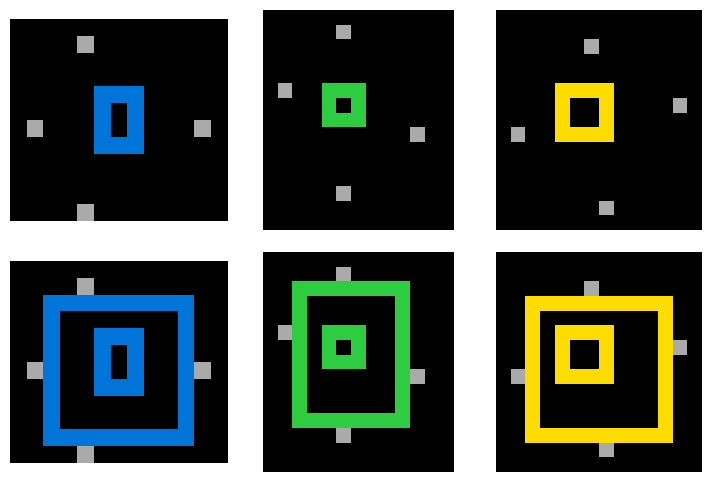

In [58]:
plot_task(data['train']['928ad970'])

In [61]:
inc_examples['train'].keys()

dict_keys(['5614dbcf_0', 'f25ffba3_0', 'f25ffba3_1', '28bf18c6_0', '28bf18c6_1', '3af2c5a8_0', '3af2c5a8_1', '62c24649_0', '62c24649_1', '67e8384a_0', '67e8384a_1', '7468f01a_0', '46f33fce_0', '46f33fce_1', '46f33fce_2', 'a740d043_0', 'a79310a0_0', 'aabf363d_0', 'aabf363d_1', 'f25fbde4_0', '1e0a9b12_0', '0d3d703e_0', '0d3d703e_1', '0d3d703e_2', '1c786137_0', '2013d3e2_0', '2013d3e2_1', '9565186b_0', 'e98196ab_0', 'e98196ab_1', 'f76d97a5_0', 'ce9e57f2_0', '9f236235_0', '46442a0e_0', '46442a0e_1', '46442a0e_2', '46442a0e_3', '46442a0e_4', '7fe24cdd_0', '7fe24cdd_1', '7fe24cdd_2', '7fe24cdd_3', '7fe24cdd_4', '0ca9ddb6_0', '543a7ed5_0', '0520fde7_0', '0520fde7_1', '0520fde7_2', 'dae9d2b5_0', 'dae9d2b5_1', 'dae9d2b5_2', '8d5021e8_0', '8d5021e8_1', '8d5021e8_2', '8d5021e8_3', '8d5021e8_4', '928ad970_0', '928ad970_1', 'b60334d2_0', 'b60334d2_1', 'b94a9452_0', 'b94a9452_1', 'b94a9452_2', 'd0f5fe59_0', 'e3497940_0', 'e3497940_1', 'e9afcf9a_0', 'e9afcf9a_1', 'e9afcf9a_2', 'e9afcf9a_3', 'e9afcf9a

In [ ]:
def get_original_as_sub(example, key, program):
    subroutine_0 = {
        "inputs": [ex['input'] for ex in example],
        "outputs": [ex['output'] for ex in example],
        "program": program
    }
    output = {
        "subroutines": [
            {"subroutine_0": subroutine_0}
        ],
        "original_task_key": key
    }
    return output
        